<h1> Bracket Calc </h1>

<h3> This tool predicts your chances of making top 8 at a bracket
given a certain selection of characters.</h3>

Author - Muna N (INF)

<H3> Setup </H3>

In [5]:
#import statements
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
import pickle
import seaborn as sns
from sklearn import metrics

In [6]:
df = pd.read_excel('Offline Data.xlsx').drop(['Unnamed: 0'], axis = 1)
df.tail()

,Tournament,Placement,Participants,DQ_Wins,Winning_Sets,Losing_Sets,Games_Won,Games_Lost,Game_3+,Sweeps,Chars_Won,Chars_Lost,Chars_All,Tourney_Win,Offline,Top_8
511,616,5,23,0,2,2,6,5,3,1,"Pikachu, Fox","Lucas, Captain Falcon","Pikachu, Fox, Lucas, Captain Falcon",0,1,1
512,617,7,34,0,4,2,9,7,4,2,"Falco, Kirby, Mario, Terry","Ice Climbers, Falco","Falco, Ice Climbers, Kirby, Mario, Terry",0,1,1
513,618,9,25,0,3,2,7,5,2,3,"King Dedede, Mario, Mii Brawler","Shulk, Wario","King Dedede, Shulk, Mario, Mii Brawler, Wario",0,1,0
514,619,9,18,0,1,2,4,5,3,0,Pikachu,"Yoshi, Sephiroth","Pikachu, Yoshi, Sephiroth",0,1,0
515,620,2,13,0,4,2,10,7,2,4,"Rosalina & Luma, Bayonetta, Mr. Game & Watch, ...",Mega Man,"Rosalina & Luma, Mega Man, Bayonetta, Mr. Game...",0,1,1


<h3> Text Preprocessing </h3>

In [8]:
#nltk.download('all')

In [9]:
# create a list text

text = list(df['Chars_All'])

In [10]:
# preprocessing loop
lemmatizer = WordNetLemmatizer()
corpus = []

for i in range(len(text)):

    r = re.sub('[^a-zA-Z]', ' ', text[i])
    r = r.lower()
    r = r.split()
    r = [word for word in r if word not in stopwords.words('english')]
    r = [lemmatizer.lemmatize(word) for word in r]
    r = ' '.join(r)
    corpus.append(r)

In [11]:
#assign corpus to df['Chars_All']

df['Chars_All'] = corpus
df['Chars_All']

0                  joker lucario mario steve link corrin
1      roy king k rool mr game watch yoshi zelda snak...
2      duck hunt lucario zelda pyra mythra captain fa...
3      kazuya bowser sephiroth mario zelda ness lucar...
4            corrin kirby pokemon trainer palutena marth
                             ...                        
511                     pikachu fox lucas captain falcon
512                  falco ice climber kirby mario terry
513            king dedede shulk mario mii brawler wario
514                              pikachu yoshi sephiroth
515    rosalina luma mega man bayonetta mr game watch...
Name: Chars_All, Length: 516, dtype: object

<h3>Pipeline Building & Model Training</h3>

In [13]:
#train/test split, 70-30
x = df['Chars_All']

y = df['Top_8']


X_train, X_test, y_train, y_test = train_test_split(x, y, 
                                                test_size=0.3, 
                                                random_state=0)

In [14]:
#TFIDF-vectorizing the list of characters we play
tvec = TfidfVectorizer(sublinear_tf=True, min_df=2,
                        ngram_range=(1, 2), 
                        stop_words='english')

In [15]:
#creating pipeline with the vectorizer and the RF model
model = make_pipeline(tvec, RandomForestClassifier(n_estimators=200, random_state=0))
model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=2, ngram_range=(1, 2),
                                 stop_words='english', sublinear_tf=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=200, random_state=0))])

<h3>Making Predictions</h3>

In [17]:
#making predictions with the model

y_pred = model.predict(X_test)

#full classification metrics report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           0       0.59      0.73      0.65        79
           1       0.62      0.46      0.53        76

    accuracy                           0.60       155
   macro avg       0.61      0.60      0.59       155
weighted avg       0.61      0.60      0.59       155



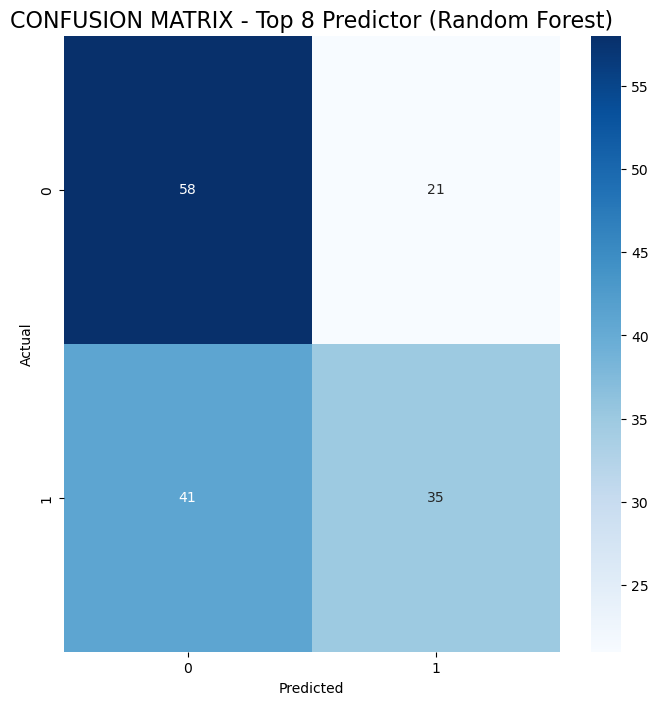

In [18]:
#graphing station for confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - Top 8 Predictor (Random Forest)", size=16)
plt.show()
print()

In [19]:
#creating a sample bracket of characters you play in bracket

bracket_str = input('Please enter the list of characters you will play against: ')
bracket_calc = model.predict([bracket_str])
bracket_p = model.predict_proba([bracket_str])[0][1]

print('The characters in your bracket path are:', bracket_str)
print('Top 8 Prediction:', bracket_calc, 'with a success probability of:',
      round((bracket_p * 100),2))

Please enter the list of characters you will play against:  Mario, Luigi, Snake, Lucario


The characters in your bracket path are: Mario, Luigi, Snake, Lucario
Top 8 Prediction: [1] with a success probability of: 81.0


<h3>Creating the Model File (for future applications)</h3>

In [21]:
# Save to file in the current working directory
pkl_filename = "model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [22]:
# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

In [23]:
# Calculate the accuracy score and predict target values
score = pickle_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
Ypredict = pickle_model.predict(X_test)

Test score: 60.00 %


In [24]:
##loading the model from the saved file
pkl_filename = "model.pkl"
with open(pkl_filename, 'rb') as f_in:
    model = pickle.load(f_in)